### GENMODEL_MSKOPT and Why We Must Modify the Code ###

The data analysed in the `scatter_compare_2.ipynb` was the following folders:

- `MC_BAYSN_NOSCATTER`
- `MC_BAYSN_PLUSSCATTER`

The results in `scatter_compare_2.ipynb` included a coherent component, making the scatter ~ 0.12mag. It should be ~ 0.1mag.

After consluting with Stephen Thorp and Matt Greyling, we ended up changing the scatter simulation to `GENMODEL_MSKOPT: 2` for the scatter and kept `GENMODEL_MSKOPT: 0`. For the no scatter. 

<h3><u>From the SNANA manual BEYSN MASKOPT feature: </u></h3>



**References**:  
K. S. Mandel et al., *MNRAS* **510**, 3939 (2022);  
S. Thorp et al., *MNRAS* **508**, 4310 (2021);  
M. Grayling et al., *MNRAS* **531**, 953 (2024).  
[3, 33, 34].

Note that host-galaxy extinction parameters (for $A_V, R_V$) are required from §9.1. The form of the host-galaxy dust extinction curve will be inherited from the Milky Way color law. Only $begin:math:text$R_V$end:math:text$-dependent extinction curves are currently supported (§4.21.2).

**Simulation input keys for `snlc_sim.exe`**:
```yaml
GENMEAN_THETA: xxx         # shape parameter
GENRANGE_THETA: xxx xxx
GENSIGMA_THETA: xxx xxx
GENMODEL_MSKOPT: <mask>    # additional settings
```

The additional settings that can be enabled via setting bits in `GENMODEL_MSKOPT` are as follows:

- `GENMODEL_MSKOPT += 1`: Enable BayeSN’s default (recommended) residual scatter model. Includes a gray component,  
  $\delta M \sim \mathcal{N}(0, \sigma_0^2)$, and a time- and wavelength-dependent component,  
  $\epsilon \sim \mathcal{N}(0, \Sigma_\epsilon)$.  
  The (co)variance of these components is set by the YAML file defining the version of the BayeSN `GENMODEL` specified in the sim input.

- `GENMODEL_MSKOPT += 2`: Enable the non-gray ($\epsilon$) component of the BayeSN residual scatter model.

- `GENMODEL_MSKOPT += 4`: Enable the gray ($\delta M$) component of the BayeSN residual scatter model.

- `GENMODEL_MSKOPT += 128`: Enable a “verbose” mode for debugging purposes.

> Multiple bits can be combined, when this is unambiguous.  
> For example, `GENMODEL_MSKOPT=6` would enable both components of the residual scatter model (equivalent to `GENMODEL_MSKOPT=1`).  
> An ambiguous combination of bits will cause the program to abort.

<h3><u>New Data Being Analyzed in this notebook: </u></h3>



In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


### Rewriting the PeakMJD Code to Eliminate the Necessity for getting Rid of Mismatches ###

In the notebook titled `scatter_compare_2.ipynb`, we were using the `PEAKMJD` entry of the individual data file which computed the Peak Modified Julian Date. There is also the `SIM_PEAKMJD` entry.

`PEAKMJD` was inconsistent between data sets which caused the +/- 7 day range around it to be inconsistent between the scatter and noscatter .DAT files. 

To fix this we will use `SIM_PEAKMJD` which is consistent between data sets and will eliminate the need to filter out rows that do not match the MJD values between the scatter and no scatter datasets. 

The main modification in the below code is switching `PEAKMJD` to `SIM_PEAKMJD` in the collect_near_peak_rows() method.


In [2]:
def collect_near_peak_rows(folder_path):
    """
    Collects all near-peak (±7 days) rows from all .DAT files in a folder.
    Returns a DataFrame with all VARLIST columns + FILENAME.
    """

    # Empty list to store all rows from all files
    all_rows = []

    # Loops through each file in the specified folder
    # and builds path to each .DAT file
    for filename in os.listdir(folder_path):
        if filename.endswith(".DAT"):
            file_path = os.path.join(folder_path, filename)


            # --- Extract PEAKMJD ---
            peak_mjd = None  # Empty variable to store PEAKMJD
            with open(file_path, "r") as f:
                for line in f:
                    
                    if "SIM_PEAKMJD" in line:
                        parts = line.strip().replace(":", "").split()
                        peak_mjd = float(parts[parts.index("SIM_PEAKMJD") + 1])
                        break

            # --- Extract OBS rows and filter by ±7 days ---
            with open(file_path, "r") as f:
                for line in f:
                    if line.startswith("OBS:"):
                        parts = line.strip().split()
                        mjd = float(parts[1])
                        band = parts[2]
                        field = parts[3]
                        fluxcal = float(parts[4])
                        fluxcalerr = float(parts[5])
                        photflag = int(parts[6])
                        gain = float(parts[7])
                        zpt = float(parts[8])
                        psf = float(parts[9])
                        sky_sig = float(parts[10])
                        sim_magobs = float(parts[11])

                        ## all_rows built up sequentially as we read each line.
                        if abs(mjd - peak_mjd) <= 7:
                            all_rows.append((
                                filename, mjd, band, field, fluxcal, fluxcalerr,
                                photflag, gain, zpt, psf, sky_sig, sim_magobs
                            ))

    return pd.DataFrame(
        all_rows,
        columns=[
            "FILENAME", "MJD", "BAND", "FIELD", "FLUXCAL", "FLUXCALERR",
            "PHOTFLAG", "GAIN", "ZPT", "PSF", "SKY_SIG", "SIM_MAGOBS"
        ]
    )



In [3]:
# --- STEP 1: Collect rows from both folders ---
nos_folder = "/Users/pittsburghgraduatestudent/repos/pippin_learn/data/MYC21_090325_BAYESN_NOSCATTER_DELR_10k_WAVEHACK"
plus_folder = "/Users/pittsburghgraduatestudent/repos/pippin_learn/data/MYC21_090325_BAYESN_PLUSSCATTER_DELR_10k_WAVEHACK"

nos_df = collect_near_peak_rows(nos_folder)
plus_df = collect_near_peak_rows(plus_folder)

# Get folder names
# Note os.path.basename() extracts the last part of the path.
nos_name = os.path.basename(nos_folder)
plus_name = os.path.basename(plus_folder)

# Build CSV filenames
nos_csv = f"{nos_name}_near_peak_rows.csv"
plus_csv = f"{plus_name}_near_peak_rows.csv"

# Save CSVs
nos_df.to_csv(f"ver_csv_files/{nos_csv}", index=False)
plus_df.to_csv(f"ver_csv_files/{plus_csv}", index=False)

# Print stats
print(f"{nos_name} near-peak rows: {len(nos_df)}")
print(f"{plus_name} near-peak rows: {len(plus_df)}")

MYC21_090325_BAYESN_NOSCATTER_DELR_10k_WAVEHACK near-peak rows: 52132
MYC21_090325_BAYESN_PLUSSCATTER_DELR_10k_WAVEHACK near-peak rows: 52132


### Merge the PLUSSCATTER entries and NOSCATTER Entries into 1 .CSV ###


In [4]:
# extracts the SN identifier from FILENAME
# SN - literal text match
# \d+ - matches one or more digits after the SN
# () - captures only this group and no other file name. 

nos_df["FILENAME"] = nos_df["FILENAME"].str.extract(r"(SN\d+)")
plus_df["FILENAME"] = plus_df["FILENAME"].str.extract(r"(SN\d+)")

merged_df = pd.merge(
    nos_df,
    plus_df,
    on=["FILENAME", "MJD", "BAND"],
    suffixes=("_NO_S", "_PLUS_S"),
    how="inner"
)

# Extracts the SN identifier from the simulation folder names.
nos_base = os.path.basename(nos_folder).replace("_NOSCATTER_DELR", "")
plus_base = os.path.basename(plus_folder).replace("_PLUSSCATTER_DELR", "")

# assert that both prefixes match
# Also a good check if you accidentally mixed up the folders.
assert nos_base == plus_base, "Folder prefixes don't match"
prefix = nos_base  # e.g., MYC21_073025_BAYESN


merged_df.to_csv(f"ver_csv_files/{prefix}_merged_near_peak_rows_n_d.csv", index=False)
print(f"Merged data saved to ver_csv_files/{prefix}_merged_near_peak_rows_n_d.csv")

Merged data saved to ver_csv_files/MYC21_090325_BAYESN_10k_WAVEHACK_merged_near_peak_rows_n_d.csv


### Check if there area any mismatches ###

Good way to test and see if the code is working propperly. If everything is going according to plan: then there are no mismatches.

NO mimsatches - everything is good 😎.

Assumption being made about the SNANA code here: that all MJD values across respective .DAT files have the same start and end date for its MJD simulation values. Meaning that it seems that the MJD value is what leads the rest of the simulation here. 

In [5]:
compare_df = pd.merge(
    nos_df,
    plus_df,
    on=["FILENAME", "MJD", "BAND"],
    suffixes=("_NO_S", "_PLUS_S"),
    how="outer",
    indicator=True  # Adds a column showing merge source
)

# --- Extract missing rows  NOSCATTER  PLUSSCATTER ---
# note: left means the first DataFrame (nos_df)
# note: right means the second DataFrame (plus_df)
left_only = compare_df[compare_df["_merge"] == "left_only"]
right_only = compare_df[compare_df["_merge"] == "right_only"]

# --- Print results ---

print(" No Match Rows: ")

print("\nRows only in NOSCATTER (left_only):")
print(left_only[["FILENAME", "MJD", "BAND"]])

print("\nRows only in PLUSSCATTER (right_only):")
print(right_only[["FILENAME", "MJD", "BAND"]])

compare_df.to_csv("compare_near_peak_rows.csv", index=False)


 No Match Rows: 

Rows only in NOSCATTER (left_only):
Empty DataFrame
Columns: [FILENAME, MJD, BAND]
Index: []

Rows only in PLUSSCATTER (right_only):
Empty DataFrame
Columns: [FILENAME, MJD, BAND]
Index: []


### Converting FLUXCAL to Magnitudes

We use the standard magnitude conversion:

$
m = 27.5 - 2.5 \log_{10}(\text{FLUXCAL})
$

Note: 27.5 is the zero point magnitude.

We start withc checking to see if any of the FLUXCAL simulations ended up returning 0. 

In [6]:
num_zeros_no_scatter = (merged_df["FLUXCAL_NO_S"]==0).sum()
print("Number of zero flux measurements (no scatter):", num_zeros_no_scatter)

num_zeros_plus_scatter = (merged_df["FLUXCAL_PLUS_S"]==0).sum()
print("Number of zero flux measurements (with scatter):", num_zeros_plus_scatter)

num_neg_no_s   = (merged_df["FLUXCAL_NO_S"] < 0).sum()
num_neg_plus_s = (merged_df["FLUXCAL_PLUS_S"] < 0).sum()

print("Negatives in FLUXCAL_NO_S:  ", num_neg_no_s)
print("Negatives in FLUXCAL_PLUS_S:", num_neg_plus_s)

Number of zero flux measurements (no scatter): 0
Number of zero flux measurements (with scatter): 0
Negatives in FLUXCAL_NO_S:   0
Negatives in FLUXCAL_PLUS_S: 0


In [7]:
pd.set_option("display.width", 200)        # wider console output
pd.set_option("display.max_columns", None) # show all columns
pd.set_option("display.max_rows", None)    # show all rows (careful with big dfs)


rows_zero_no_s = merged_df[merged_df["FLUXCAL_NO_S"] == 0]
rows_zero_plus_s = merged_df[merged_df["FLUXCAL_PLUS_S"] == 0]

print("Rows with zero flux (no scatter):")
print(rows_zero_no_s.to_string(index=False))  # no wrapping or backslashes

print("\nRows with zero flux (with scatter):")
print(rows_zero_plus_s.to_string(index=False))

Rows with zero flux (no scatter):
Empty DataFrame
Columns: [FILENAME, MJD, BAND, FIELD_NO_S, FLUXCAL_NO_S, FLUXCALERR_NO_S, PHOTFLAG_NO_S, GAIN_NO_S, ZPT_NO_S, PSF_NO_S, SKY_SIG_NO_S, SIM_MAGOBS_NO_S, FIELD_PLUS_S, FLUXCAL_PLUS_S, FLUXCALERR_PLUS_S, PHOTFLAG_PLUS_S, GAIN_PLUS_S, ZPT_PLUS_S, PSF_PLUS_S, SKY_SIG_PLUS_S, SIM_MAGOBS_PLUS_S]
Index: []

Rows with zero flux (with scatter):
Empty DataFrame
Columns: [FILENAME, MJD, BAND, FIELD_NO_S, FLUXCAL_NO_S, FLUXCALERR_NO_S, PHOTFLAG_NO_S, GAIN_NO_S, ZPT_NO_S, PSF_NO_S, SKY_SIG_NO_S, SIM_MAGOBS_NO_S, FIELD_PLUS_S, FLUXCAL_PLUS_S, FLUXCALERR_PLUS_S, PHOTFLAG_PLUS_S, GAIN_PLUS_S, ZPT_PLUS_S, PSF_PLUS_S, SKY_SIG_PLUS_S, SIM_MAGOBS_PLUS_S]
Index: []


In [8]:
merged_df["MAG_NO_S"] = 27.5 - 2.5 * np.log10(merged_df["FLUXCAL_NO_S"])
merged_df["MAG_PLUS_S"] = 27.5 - 2.5 * np.log10(merged_df["FLUXCAL_PLUS_S"])

### RMS Scatter of Magnitudes

$\huge \sigma_{\text{scatter}} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(m_{+,i} - m_{-,i})^2}$  

Where:  
- **$\sigma_{\text{scatter}}$** = RMS deviation between scatter and no-scatter magnitudes  
- **$N$** = number of observations (data points)  
- **$m_{+,i}$** = magnitude with scatter for the $i^{\text{th}}$ observation  
- **$m_{-,i}$** = magnitude without scatter for the $i^{\text{th}}$ observation  

**Conceptually:** We are measuring **how far the scatter simulation deviates from the no-scatter (baseline) magnitudes** on average.  

In [9]:
# --- Compute Δm = m_plus - m_no ---
merged_df["DELTA_M"] = merged_df["MAG_PLUS_S"] - merged_df["MAG_NO_S"]

# --- Compute RMS per band ---
rms_results = []

for band in ["LSST-u", "LSST-g", "LSST-r", "LSST-i", "LSST-z"]:
    band_mask = merged_df["BAND"].str.contains(band)
    band_data = merged_df.loc[band_mask, "DELTA_M"]
    N = len(band_data)
    rms = np.sqrt(np.mean(band_data**2))
    rms_results.append((band, N, rms))

# Print RMS results
print("\nRMS Results:")
for band, N, rms in rms_results:
    print(f"RMS_{band}: {rms:.6f} (N = {N})")



RMS Results:
RMS_LSST-u: 0.084520 (N = 4851)
RMS_LSST-g: 0.066177 (N = 9608)
RMS_LSST-r: 0.055530 (N = 12778)
RMS_LSST-i: 0.068634 (N = 12889)
RMS_LSST-z: 0.059134 (N = 12006)


### RMS vs. $\lambda$ in ($\AA$)

Here we will fit a relationship between the RMS scatter between PLUSSCATTER/NOSCATTER datasets and the wavelength of the band. 

Values for the `BAND_LAMBDA` were taken from a list of effective wavelengths for the LSST filter bands in the following paper (Fig. 1) (Huber et. al. 2021):

https://www.aanda.org/articles/aa/full_html/2021/02/aa39218-20/aa39218-20.html

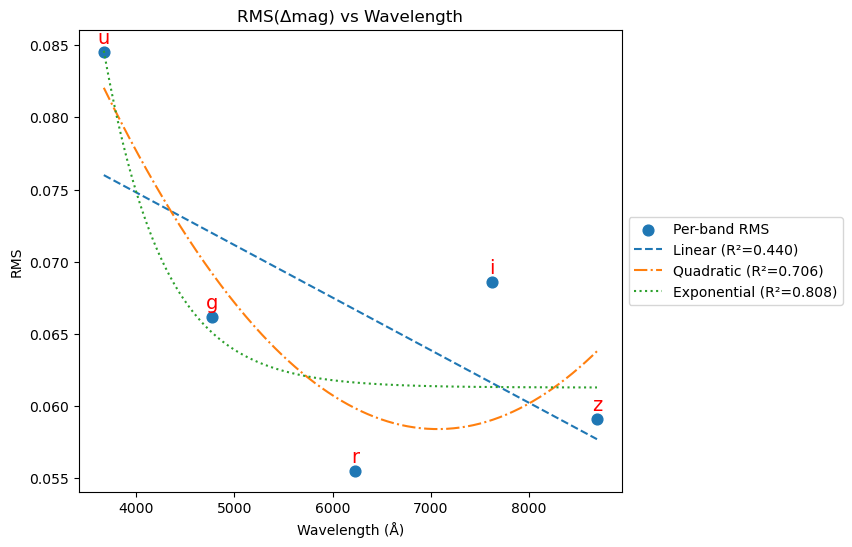

Linear fit:  RMS(λ) = a*λ + b
  a = -3.642907e-06, b = 0.089376, R² = 0.440

Quadratic fit:  RMS(λ) = c*λ² + a*λ + b
  c = 2.047537e-09, a = -2.894536e-05, b = 0.160715, R² = 0.706

Exponential fit: RMS(λ) = a * exp(b * λ) + c
  a = 9.800814e+00, b = -1.645569e-03, c = 0.061293, R² = 0.808


In [20]:
# Units are Angstroms (Å)
BAND_LAMBDA = {
    "LSST-u": 3671,
    "LSST-g": 4770,
    "LSST-r": 6231,
    "LSST-i": 7625,
    "LSST-z": 8691,
}

# Make empty lists
wavelengths = []
rms_values = []

# Loop through each tuple in rms_results
for band, N, rms in rms_results:
    # Look up the wavelength for this band
    # NOTE: BAND_LAMBDA is a dictionary mapping band names to wavelengths
    wavelength = BAND_LAMBDA[band]
    wavelengths.append(wavelength)

    # Add the RMS value
    rms_values.append(rms)

wavelengths = np.array(wavelengths)
rms_values  = np.array(rms_values)

# ---- Linear fit RMS(λ) = a*λ + b
a1, b1 = np.polyfit(wavelengths, rms_values, deg=1)
y_lin = a1 * wavelengths + b1
r2_lin = 1 - np.sum((rms_values - y_lin)**2) / np.sum((rms_values - np.mean(rms_values))**2)

# ---- Quadratic fit RMS(λ) = c*λ² + a*λ + b
c2, a2, b2 = np.polyfit(wavelengths, rms_values, deg=2)
y_quad = c2 * wavelengths**2 + a2 * wavelengths + b2
r2_quad = 1 - np.sum((rms_values - y_quad)**2) / np.sum((rms_values - np.mean(rms_values))**2)

# ---- Exponential fit: RMS(λ) = a * exp(b * λ) + c
# Had to use lambda_val instead of lambda
# because lambda is a reserved keyword in Python.
def exp_func(lambda_val, a, b, c):
    return a * np.exp(b * lambda_val) + c

#NOTE: p0 provides initial guesses for a, b, c
popt, _ = curve_fit(exp_func, wavelengths, rms_values, p0=(0.01, 0.0001, 0.05))
a_exp, b_exp, c_exp = popt
y_exp = exp_func(wavelengths, *popt)
r2_exp = 1 - np.sum((rms_values - y_exp)**2) / np.sum((rms_values - np.mean(rms_values))**2)

# ---- Calculating values that will be part of our fit curves.
lambda_values = np.linspace(wavelengths.min(), wavelengths.max(), 300)
y_lin_grid  = a1 * lambda_values + b1
y_quad_grid = c2 * lambda_values**2 + a2 * lambda_values + b2
y_exp_grid  = exp_func(lambda_values, popt[0], popt[1], popt[2])
# ---- Plot
plt.figure(figsize=(7,6))
plt.scatter(wavelengths, rms_values, s=60, label="Per-band RMS")
plt.plot(lambda_values, y_lin_grid,  "--", label=f"Linear (R²={r2_lin:.3f})")
plt.plot(lambda_values, y_quad_grid, "-.", label=f"Quadratic (R²={r2_quad:.3f})")
plt.plot(lambda_values, y_exp_grid,   ":", label=f"Exponential (R²={r2_exp:.3f})")

plt.xlabel("Wavelength (Å)")
plt.ylabel("RMS")
plt.title("RMS(Δmag) vs Wavelength")

# Annotate each data point with its band (u,g,r,i,z)
for (band, _, rms_val), wave in zip(rms_results, wavelengths):
    band_tag = band.replace("LSST-", "")
    plt.annotate(band_tag,
                 (wave, rms_val),
                 textcoords="offset points",
                 xytext=(0, 6),
                 ha="center",
                 color = "red",
                 fontsize=14)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# ---- Print results
print("Linear fit:  RMS(λ) = a*λ + b")
print(f"  a = {a1:.6e}, b = {b1:.6f}, R² = {r2_lin:.3f}")

print("\nQuadratic fit:  RMS(λ) = c*λ² + a*λ + b")
print(f"  c = {c2:.6e}, a = {a2:.6e}, b = {b2:.6f}, R² = {r2_quad:.3f}")

print("\nExponential fit: RMS(λ) = a * exp(b * λ) + c")
print(f"  a = {a_exp:.6e}, b = {b_exp:.6e}, c = {c_exp:.6f}, R² = {r2_exp:.3f}")

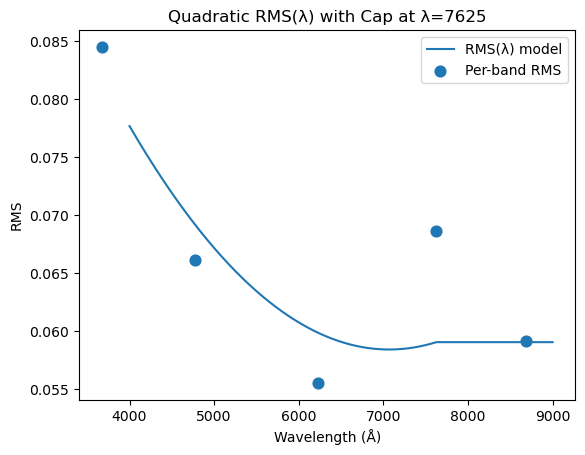

In [13]:

def rms_lambda_quad(lam):
    """
    Quadratic RMS(λ) with RMS cap at λ=7625.
      RMS(λ) = c2*λ² + a2*λ + b2
    If λ > 7625, returns RMS(7625).
    """
    lam = np.asarray(lam, float)

    # compute f(7625) once
    rms_at_7625 = c2*7625**2 + a2*7625 + b2

    # use np.where to cap values
    return np.where(lam > 7625,
                    rms_at_7625,
                    c2*lam**2 + a2*lam + b2)

# Plot
lam_values = np.linspace(4000, 9000, 500)
rms_model = rms_lambda_quad(lam_values)

plt.plot(lam_values, rms_model, label="RMS(λ) model")
plt.scatter(wavelengths, rms_values, s=60, label="Per-band RMS")
plt.xlabel("Wavelength (Å)")
plt.ylabel("RMS")
plt.title("Quadratic RMS(λ) with Cap at λ=7625")
plt.legend()
plt.show()

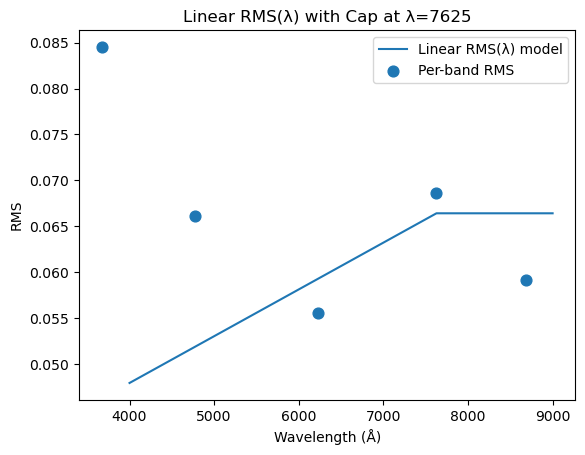

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Linear fit coefficients ----
a_lin = 5.091544e-06
b_lin = 0.027604

def rms_lambda_linear(lam):
    """
    Linear RMS(λ) with RMS cap at λ=7625.
      RMS(λ) = a*λ + b
    If λ > 7625, returns RMS(7625).
    """
    lam = np.asarray(lam, float)

    # compute f(7625) once
    rms_at_7625 = a_lin*7625 + b_lin

    # use np.where to cap values
    return np.where(lam > 7625,
                    rms_at_7625,
                    a_lin*lam + b_lin)

# ---- Plot ----
lam_values = np.linspace(4000, 9000, 500)
rms_model = rms_lambda_linear(lam_values)

plt.plot(lam_values, rms_model, label="Linear RMS(λ) model")
plt.scatter(wavelengths, rms_values, s=60, label="Per-band RMS")
plt.xlabel("Wavelength (Å)")
plt.ylabel("RMS")
plt.title("Linear RMS(λ) with Cap at λ=7625")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import warnings

class BoundedRMS:
    """
    Wrap any RMS(lambda) function with domain and value sanity checks.

    Parameters
    ----------
    func : callable
        The raw RMS(λ) function, e.g. your quadratic or exponential fit.
        Must accept numpy array or float and return same shape.
    lam_min, lam_max : float
        Valid wavelength interval [lam_min, lam_max] for which the fit is trusted.
        (Use the min/max of the wavelengths you actually fit.)
    value_bounds : tuple(float|None, float|None), default=(0.0, None)
        Clamp the output RMS into [lo, hi] if not None. By default, enforces RMS ≥ 0.
        Set hi (e.g., 0.5) if you want an upper bound too.
    oob : {'clip','warn','raise','nan'}, default='clip'
        Behavior for out-of-bounds λ:
          - 'clip': evaluate at clipped λ (to nearest endpoint)
          - 'warn': evaluate at unclipped λ but emit a warning
          - 'raise': raise a ValueError
          - 'nan': return NaN for those entries
    """
    def __init__(self, func, lam_min, lam_max, value_bounds=(0.0, None), oob='clip'):
        assert lam_min <= lam_max, "lam_min must be <= lam_max"
        assert oob in {'clip','warn','raise','nan'}
        self.func = func
        self.lam_min = float(lam_min)
        self.lam_max = float(lam_max)
        self.value_bounds = value_bounds
        self.oob = oob

    def __call__(self, lam):
        lam = np.asarray(lam, dtype=float)

        # identify out-of-bounds
        oob_mask = (lam < self.lam_min) | (lam > self.lam_max)

        lam_eval = lam.copy()
        if np.any(oob_mask):
            if self.oob == 'clip':
                lam_eval = np.clip(lam_eval, self.lam_min, self.lam_max)
            elif self.oob == 'warn':
                warnings.warn(
                    f"λ outside fit range [{self.lam_min}, {self.lam_max}] — results may be unreliable.",
                    RuntimeWarning
                )
            elif self.oob == 'raise':
                bad_vals = lam[oob_mask]
                raise ValueError(f"Out-of-range λ: {bad_vals} (valid range [{self.lam_min}, {self.lam_max}])")
            elif self.oob == 'nan':
                # we'll compute normally, then overwrite oob entries with NaN
                pass

        # evaluate the raw function
        rms = self.func(lam_eval)

        # apply value clamps (e.g., RMS >= 0)
        lo, hi = self.value_bounds
        if lo is not None:
            rms = np.maximum(rms, lo)
        if hi is not None:
            rms = np.minimum(rms, hi)

        if self.oob == 'nan' and np.any(oob_mask):
            rms = np.asarray(rms)
            rms[oob_mask] = np.nan

        return rms


# your fitted coefficients
# Quadratic: RMS(λ) = c*λ² + a*λ + b
c_q = 2.819345e-09
a_q = -2.982278e-05
b_q = 0.131866

def rms_quad(lam):
    lam = np.asarray(lam, float)
    return c_q*lam**2 + a_q*lam + b_q

# Exponential: RMS(λ) = a * exp(b*λ) + c
a_e = 2.434836e-07
b_e = 1.445187e-03
c_e = 0.053519

def rms_exp(lam):
    lam = np.asarray(lam, float)
    return a_e * np.exp(b_e * lam) + c_e

# define trusted wavelength range from your data (example: min/max of g,r,i effective λ)
# replace these with the exact values you used
lam_min = 470.0  # nm
lam_max = 770.0  # nm

# wrap with sanity protection
rms_quad_safe = BoundedRMS(rms_quad, lam_min, lam_max, value_bounds=(0.0, None), oob='clip')
rms_exp_safe  = BoundedRMS(rms_exp,  lam_min, lam_max, value_bounds=(0.0, None), oob='clip')

# demo calls
lam_test = np.array([350, 480, 620, 760, 1200], dtype=float)  # includes OOB points
print("quad:", rms_quad_safe(lam_test))
print("exp :", rms_exp_safe(lam_test))

quad: [0.11847209 0.11820064 0.11445963 0.11082914 0.11057405]
exp : [0.05351948 0.05351949 0.0535196  0.05351973 0.05351974]


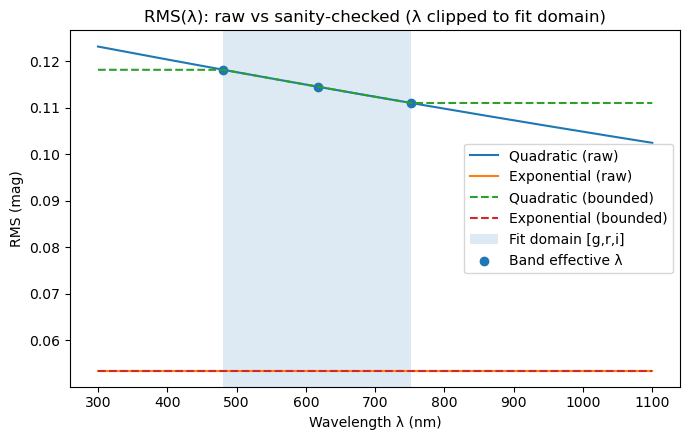

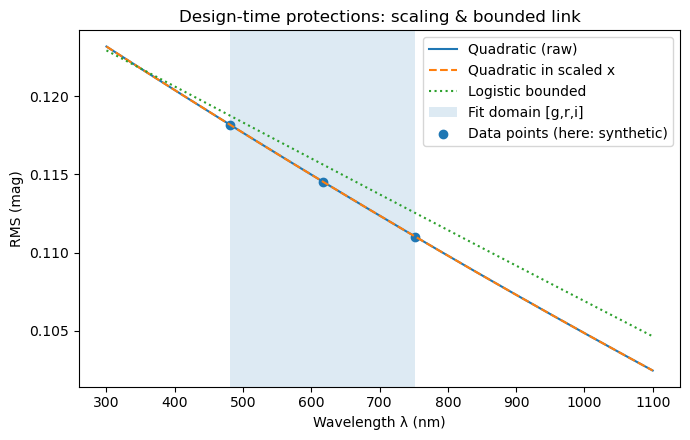

In [ ]:
# RMS(λ) sanity-check demo: raw vs bounded + scaled/logistic variants
# ---------------------------------------------------------------
# Drop this in a notebook cell or run as a script.
# It will produce two figures.

import numpy as np
import matplotlib.pyplot as plt
import warnings

# --- Your fit coefficients ----------------------------------------------------
# Quadratic: RMS(λ) = c*λ² + a*λ + b
c_q = 2.819345e-09
a_q = -2.982278e-05
b_q = 0.131866

# Exponential: RMS(λ) = a * exp(b*λ) + c
a_e = 2.434836e-07
b_e = 1.445187e-03
c_e = 0.053519

def rms_quad(lam):
    lam = np.asarray(lam, float)
    return c_q*lam**2 + a_q*lam + b_q

def rms_exp(lam):
    lam = np.asarray(lam, float)
    return a_e * np.exp(b_e * lam) + c_e

# --- Sanity-check wrapper -----------------------------------------------------
class BoundedRMS:
    """
    Wrap any RMS(lambda) function with domain and value sanity checks.

    Parameters
    ----------
    func : callable
        Raw RMS(λ) function (numpy-friendly).
    lam_min, lam_max : float
        Trusted wavelength interval [lam_min, lam_max].
    value_bounds : (lo, hi) where each is float or None
        Clamp the output; default enforces RMS >= 0.
    oob : {'clip','warn','raise','nan'}
        Out-of-bounds behavior for λ outside [lam_min, lam_max].
    """
    def __init__(self, func, lam_min, lam_max, value_bounds=(0.0, None), oob='clip'):
        assert lam_min <= lam_max, "lam_min must be <= lam_max"
        assert oob in {'clip','warn','raise','nan'}
        self.func = func
        self.lam_min = float(lam_min)
        self.lam_max = float(lam_max)
        self.value_bounds = value_bounds
        self.oob = oob

    def __call__(self, lam):
        lam = np.asarray(lam, dtype=float)
        oob_mask = (lam < self.lam_min) | (lam > self.lam_max)

        lam_eval = lam.copy()
        if np.any(oob_mask):
            if self.oob == 'clip':
                lam_eval = np.clip(lam_eval, self.lam_min, self.lam_max)
            elif self.oob == 'warn':
                warnings.warn(
                    f"λ outside fit range [{self.lam_min}, {self.lam_max}] — results may be unreliable.",
                    RuntimeWarning
                )
            elif self.oob == 'raise':
                bad = lam[oob_mask]
                raise ValueError(f"Out-of-range λ: {bad} (valid [{self.lam_min}, {self.lam_max}])")
            elif self.oob == 'nan':
                # evaluate normally, then set OOB entries to NaN below
                pass

        y = self.func(lam_eval)

        # Clamp outputs (e.g., RMS >= 0)
        lo, hi = self.value_bounds
        if lo is not None:
            y = np.maximum(y, lo)
        if hi is not None:
            y = np.minimum(y, hi)

        if self.oob == 'nan' and np.any(oob_mask):
            y = np.asarray(y)
            y[oob_mask] = np.nan

        return y

# --- LSST effective wavelengths (edit to your exact values if needed) --------
lam_g, lam_r, lam_i = 481.0, 617.0, 752.0   # nm
lam_min, lam_max = min(lam_g, lam_r, lam_i), max(lam_g, lam_r, lam_i)

# Safe wrappers (oob strategy and value bounds are configurable)
rms_quad_safe = BoundedRMS(rms_quad, lam_min, lam_max, value_bounds=(0.0, None), oob='clip')
rms_exp_safe  = BoundedRMS(rms_exp,  lam_min, lam_max, value_bounds=(0.0, None), oob='clip')

# --- Grids for plotting -------------------------------------------------------
lam_grid_wide = np.linspace(300, 1100, 800)    # deliberately wider than fit domain
lam_grid_fit  = np.linspace(lam_min, lam_max, 200)

# --- Figure 1: Raw vs bounded -------------------------------------------------
plt.figure(figsize=(7, 4.5))
plt.plot(lam_grid_wide, rms_quad(lam_grid_wide), label="Quadratic (raw)")
plt.plot(lam_grid_wide, rms_exp(lam_grid_wide),  label="Exponential (raw)")
plt.plot(lam_grid_wide, rms_quad_safe(lam_grid_wide), linestyle='--', label="Quadratic (bounded)")
plt.plot(lam_grid_wide, rms_exp_safe(lam_grid_wide),  linestyle='--', label="Exponential (bounded)")

plt.axvspan(lam_min, lam_max, alpha=0.15, label="Fit domain [g,r,i]")
plt.scatter([lam_g, lam_r, lam_i],
            [rms_quad([lam_g])[0], rms_quad([lam_r])[0], rms_quad([lam_i])[0]],
            label="Band effective λ")

plt.title("RMS(λ): raw vs sanity‑checked (λ clipped to fit domain)")
plt.xlabel("Wavelength λ (nm)")
plt.ylabel("RMS (mag)")
plt.legend(loc="best")
plt.tight_layout()
# plt.savefig("rms_lambda_bounded.png", dpi=160)
plt.show()

# --- Figure 2: Design‑time protections (scaling + bounded logistic) ----------
# Map λ to [-1, 1] (Chebyshev-friendly)
def to_unit(l):      # [0,1]
    return (l - lam_min) / (lam_max - lam_min)

def to_cheby(l):     # [-1,1]
    return 2*to_unit(l) - 1

# If you have measured RMS at g/r/i, replace RMS_obs below with those values.
# Here we synthesize "data" from the quadratic fit just for visualization.
RMS_obs = np.array([rms_quad(lam_g), rms_quad(lam_r), rms_quad(lam_i)], float)
x_obs   = to_cheby(np.array([lam_g, lam_r, lam_i], float))

# Quadratic fit in scaled variable x
coef = np.polyfit(x_obs, RMS_obs, deg=2)  # α, β, γ

def rms_quad_scaled(lam_query):
    xq = to_cheby(np.asarray(lam_query, float))
    y  = np.polyval(coef, xq)
    return np.maximum(y, 0.0)

# Bounded logistic model in x (keeps RMS in [Lmin, Lmax])
def logistic_rms(x, a, b, Lmin=0.0, Lmax=0.25):
    return Lmin + (Lmax - Lmin) / (1 + np.exp(-(a*x + b)))

# Fit a,b by a simple grid search (no external deps)
a_grid = np.linspace(-10, 10, 401)
b_grid = np.linspace(-10, 10, 401)
best = None
for a in a_grid:
    # evaluate all b at once for speed
    y_pred = np.array([logistic_rms(x_obs, a, b) for b in b_grid])  # shape (len(b), 3)
    se = np.sum((y_pred - RMS_obs)**2, axis=1)
    j = np.argmin(se)
    if best is None or se[j] < best[0]:
        best = (se[j], a, b_grid[j])
se_min, a_best, b_best = best

def rms_logistic(lam_query, Lmin=0.0, Lmax=0.25):
    xq = to_cheby(np.asarray(lam_query, float))
    return logistic_rms(xq, a_best, b_best, Lmin=Lmin, Lmax=Lmax)

plt.figure(figsize=(7, 4.5))
plt.plot(lam_grid_wide, rms_quad(lam_grid_wide), label="Quadratic (raw)")
plt.plot(lam_grid_wide, rms_quad_scaled(lam_grid_wide), linestyle='--', label="Quadratic in scaled x")
plt.plot(lam_grid_wide, rms_logistic(lam_grid_wide), linestyle=':', label="Logistic bounded")
plt.axvspan(lam_min, lam_max, alpha=0.15, label="Fit domain [g,r,i]")
plt.scatter([lam_g, lam_r, lam_i], RMS_obs, label="Data points (here: synthetic)")
plt.title("Design‑time protections: scaling & bounded link")
plt.xlabel("Wavelength λ (nm)")
plt.ylabel("RMS (mag)")
plt.legend(loc="best")
plt.tight_layout()
# plt.savefig("rms_lambda_design_time.png", dpi=160)
plt.show()

# --- Notes -------------------------------------------------------------------
# • Change `oob` to 'warn' | 'raise' | 'nan' in BoundedRMS to control what happens outside [lam_min, lam_max].
# • Add an upper clamp via value_bounds=(0.0, 0.5) if you want to

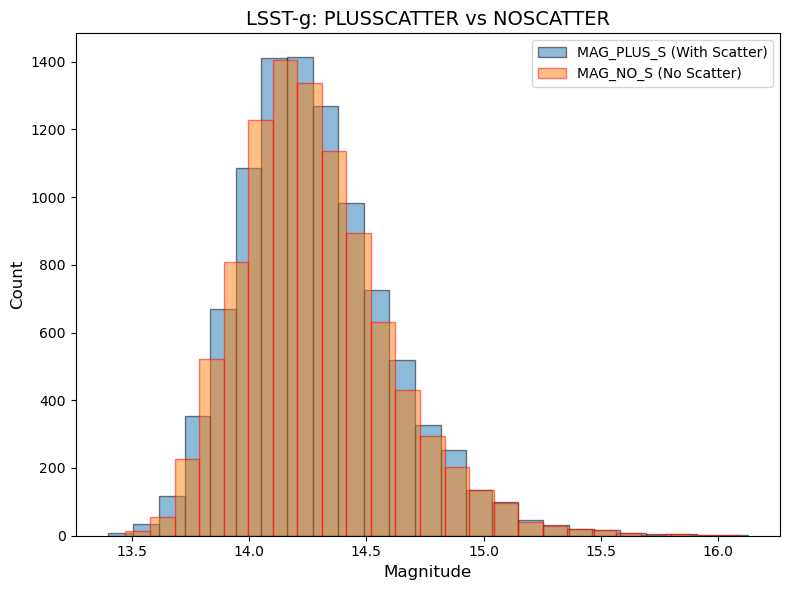

In [ ]:
# --- Filter to LSST-g band only ---
g_band_mask = merged_df["BAND"].str.contains("LSST-g")
g_band_df = merged_df[g_band_mask].copy()

# --- Remove non-finite entries ---
# There were errors where we divide by zero somewhere within the data sets of the simulation. 

g_band_df = g_band_df[
    np.isfinite(g_band_df["MAG_PLUS_S"]) &
    np.isfinite(g_band_df["MAG_NO_S"])
]

# --- Plot overlaid histograms ---
plt.figure(figsize=(8, 6))
plt.hist(g_band_df["MAG_PLUS_S"], bins=25, alpha=0.5, label="MAG_PLUS_S (With Scatter)", edgecolor='k')
plt.hist(g_band_df["MAG_NO_S"], bins=25, alpha=0.5, label="MAG_NO_S (No Scatter)", edgecolor='r')

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("LSST-g: PLUSSCATTER vs NOSCATTER", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

### The Following Code is to be Used in Case of  FluxCal values beign zero leading to inf MAG Values ###

The SNANNA simulations do not just simulate SNIa but rather how they are being detected.

Things like detector saturation and telescope parameters are also considered. 

When we set change in z to be  a delta funciton in our last experimental run (see `MYC21_073025_SIM_DELR.ipynb`) we ended up 
getting an over-saturated detector. 

To avoid this we ended up raising the saturation limit of this detector as part of the simulation: NPE_PIXEL_SATURATE (e.g., 1000000).


In [ ]:
band_data = merged_df.loc[band_mask, "DELTA_M"]
print(f"\n--- {band} ---")
print("NaNs:", band_data.isna().sum())
print("Infs:", np.isinf(band_data).sum())


--- LSST-i ---
NaNs: 0
Infs: 0


In [ ]:
# LOTS OF INIFINITE VALUES IN THE DATA. HERE IS THE VERSION OF THE CODE THAT CLEANS FOR THAT #

# --- Compute Δm = m_plus - m_no ---
merged_df["DELTA_M"] = merged_df["MAG_PLUS_S"] - merged_df["MAG_NO_S"]

# --- Compute RMS per band, with cleaning ---
rms_results = []

for band in ["LSST-g", "LSST-r", "LSST-i"]:
    band_mask = merged_df["BAND"].str.contains(band)
    band_data = merged_df.loc[band_mask, "DELTA_M"]
    
    # Clean NaNs and infs
    clean_band_data = band_data.replace([np.inf, -np.inf], np.nan).dropna()
    
    N = len(clean_band_data)
    rms = np.sqrt(np.mean(clean_band_data**2)) if N > 0 else np.nan
    rms_results.append((band, N, rms))

# --- Print Results ---
print("\nRMS Results:")
for band, N, rms in rms_results:
    print(f"RMS_{band}: {rms:.6f} (N = {N})")


RMS Results:
RMS_LSST-g: 0.053759 (N = 9539)
RMS_LSST-r: 0.055502 (N = 12684)
RMS_LSST-i: 0.068386 (N = 12799)


### Plotting PEAKMAG_g distributions for Scatter and no scatter ###

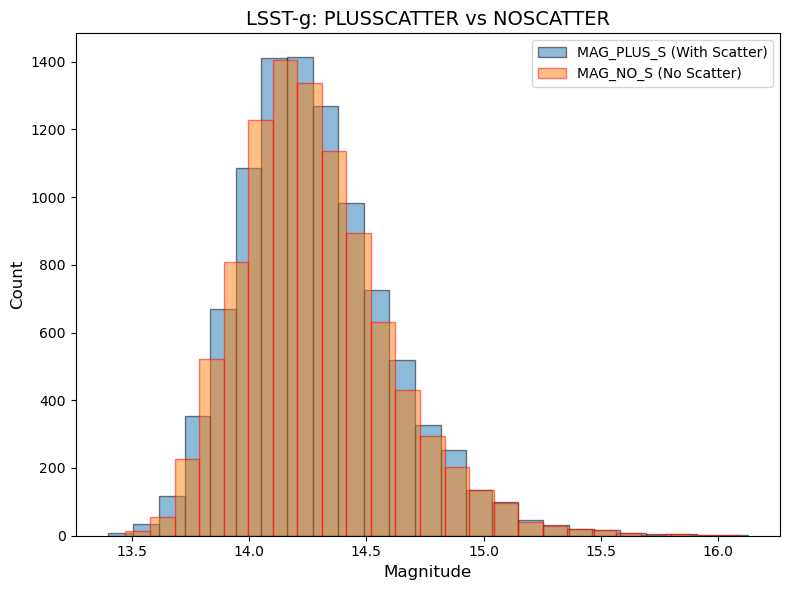

In [ ]:
# --- Filter to LSST-g band only ---
g_band_mask = merged_df["BAND"].str.contains("LSST-g")
g_band_df = merged_df[g_band_mask].copy()

# --- Remove non-finite entries ---
# There were errors where we divide by zero somewhere within the data sets of the simulation. 

g_band_df = g_band_df[
    np.isfinite(g_band_df["MAG_PLUS_S"]) &
    np.isfinite(g_band_df["MAG_NO_S"])
]

# --- Plot overlaid histograms ---
plt.figure(figsize=(8, 6))
plt.hist(g_band_df["MAG_PLUS_S"], bins=25, alpha=0.5, label="MAG_PLUS_S (With Scatter)", edgecolor='k')
plt.hist(g_band_df["MAG_NO_S"], bins=25, alpha=0.5, label="MAG_NO_S (No Scatter)", edgecolor='r')

plt.xlabel("Magnitude", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("LSST-g: PLUSSCATTER vs NOSCATTER", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()